In [50]:
# ============================================================
# 05_production_ready_pipeline.ipynb
# Goal:
# Prepare the EV Range Prediction model for production use by
# defining training, prediction, serialization, and reproducibility
# steps that will later be moved into train.py and predict.py.
# ============================================================

In [51]:
# ============================================
# Cell 2 — Imports & Paths
# ============================================

import joblib
import json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DATA_PROCESSED = Path("../data/processed")
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)
################################################
from pathlib import Path
import pandas as pd
import joblib

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

In [52]:
# ============================================
# Cell 3 — Load Trained Model & Test Data
# ============================================

model_path = MODELS_DIR / "ev_range_model.joblib"

if not model_path.exists():
    raise FileNotFoundError(
        f"Model file not found at {model_path}. "
        "You must SAVE the trained model in Notebook 2 before running Notebook 5."
    )

model = joblib.load(model_path)

X_test = pd.read_csv(DATA_PROCESSED / "X_test.csv")
y_test = pd.read_csv(DATA_PROCESSED / "y_test.csv").squeeze()

print("Model loaded from:", model_path.resolve())
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Model loaded from: /Users/saam/PycharmProjects/ev-range-prediction/models/ev_range_model.joblib
X_test shape: (9917, 83)
y_test shape: (9917,)


In [53]:
import joblib
from pathlib import Path

obj = joblib.load(Path("../models/ev_range_model.joblib"))
print(type(obj))

<class 'sklearn.pipeline.Pipeline'>


In [54]:
import shutil
import joblib
from pathlib import Path
from sklearn.pipeline import Pipeline

# Source = the GOOD pipeline
src = Path("models/ev_range_model.joblib")

# Destination = project root /models (one level up from /notebooks)
dst = Path("..") / "models" / "ev_range_model.joblib"
dst.parent.mkdir(parents=True, exist_ok=True)

print("Copying from:", src.resolve())
print("Copying to:", dst.resolve())

shutil.copy2(src, dst)

# Verify destination is now a Pipeline
obj = joblib.load(dst)
print("✅ Destination type:", type(obj))

if not isinstance(obj, Pipeline):
    raise TypeError("Destination is still not a Pipeline — copy failed or wrong source.")

Copying from: /Users/saam/PycharmProjects/ev-range-prediction/notebooks/models/ev_range_model.joblib
Copying to: /Users/saam/PycharmProjects/ev-range-prediction/models/ev_range_model.joblib
✅ Destination type: <class 'sklearn.pipeline.Pipeline'>


In [55]:
# ============================================
# Cell 4 — Generate Predictions (FINAL - ROBUST PATHS)
# Goal: Load the full trained Pipeline and generate predictions on X_test.
# ============================================

import joblib
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline

# --- Robust project root detection ---
# Works whether CWD is repo root or /notebooks.
CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent

MODEL_PATH = PROJECT_ROOT / "models" / "ev_range_model.joblib"
X_TEST_PATH = PROJECT_ROOT / "data" / "processed" / "X_test.csv"

print("CWD:", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODEL_PATH:", MODEL_PATH)
print("X_TEST_PATH:", X_TEST_PATH)
print("Model exists:", MODEL_PATH.exists())
print("X_test exists:", X_TEST_PATH.exists())

# --- Load model (must be full Pipeline) ---
pipe_or_obj = joblib.load(MODEL_PATH)
print("Loaded object type:", type(pipe_or_obj))

if not isinstance(pipe_or_obj, Pipeline):
    raise TypeError("Loaded model is not a sklearn Pipeline. Aborting.")

model_pipe = pipe_or_obj

# --- Load test data and predict ---
X_test = pd.read_csv(X_TEST_PATH)
y_pred = model_pipe.predict(X_test)

print("✅ Predictions generated successfully.")
print("y_pred shape:", y_pred.shape)
print("y_pred sample:", y_pred[:5])

CWD: /Users/saam/PycharmProjects/ev-range-prediction/notebooks
PROJECT_ROOT: /Users/saam/PycharmProjects/ev-range-prediction
MODEL_PATH: /Users/saam/PycharmProjects/ev-range-prediction/models/ev_range_model.joblib
X_TEST_PATH: /Users/saam/PycharmProjects/ev-range-prediction/data/processed/X_test.csv
Model exists: True
X_test exists: True
Loaded object type: <class 'sklearn.pipeline.Pipeline'>
✅ Predictions generated successfully.
y_pred shape: (9917,)
y_pred sample: [ 69.27333333 249.81       175.14        68.57333333  70.95      ]


In [56]:
# ============================================
# Cell 5 — Build & Save Predictions for Downstream Use
# Goal: Create a minimal pred_df for reuse (scripts, metrics, sanity checks).
# ============================================

import pandas as pd
from pathlib import Path

# --- Resolve project root (robust) ---
CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# --- Load y_test ---
y_test = pd.read_csv(DATA_PROCESSED / "y_test.csv")

# --- Build prediction dataframe ---
pred_df = pd.DataFrame({
    "y_true": y_test.squeeze(),  # ensure Series
    "y_pred": y_pred
})

# --- Save for downstream use ---
out_path = DATA_PROCESSED / "predictions.csv"
pred_df.to_csv(out_path, index=False)

print("✅ Saved predictions to:", out_path.resolve())
pred_df.head()

✅ Saved predictions to: /Users/saam/PycharmProjects/ev-range-prediction/data/processed/predictions.csv


,y_true,y_pred
0,0,69.273333
1,0,249.810000
2,0,175.140000
3,0,68.573333
4,0,70.950000


In [57]:
# ============================================
# Cell 6 — Quick Sanity Metrics (Notebook 05 only)
# Goal: Confirm metrics match training-time expectations.
# ============================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

mae = mean_absolute_error(pred_df["y_true"], pred_df["y_pred"])
rmse = np.sqrt(mean_squared_error(pred_df["y_true"], pred_df["y_pred"]))
r2 = r2_score(pred_df["y_true"], pred_df["y_pred"])

pd.DataFrame(
    {
        "MAE (miles)": [mae],
        "RMSE (miles)": [rmse],
        "R²": [r2],
    }
)

,MAE (miles),RMSE (miles),R²
0,83.21015,98.841227,-1.578976


In [58]:
# ============================================
# Cell 7 — Notebook 5 Completion Check
# ============================================

assert (DATA_PROCESSED / "predictions.csv").exists(), "predictions.csv missing"
assert model_path.exists(), "model artifact missing"

print("Notebook 5 complete ✔")

Notebook 5 complete ✔


In [59]:
# ============================================
# Cell 8 — Save Example Input/Output (For predict.py)
# Goal: Create a single-row inference example and save as JSON.
# ============================================

import json
import pandas as pd
from pathlib import Path

# --- Resolve project root (robust) ---
CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# --- Load test features ---
X_test = pd.read_csv(DATA_PROCESSED / "X_test.csv")

# --- Select a single example row (first row is fine) ---
sample_row = X_test.iloc[[0]]  # keep as DataFrame

# --- Generate prediction for this single row ---
sample_pred = model_pipe.predict(sample_row)[0]

# --- Build example I/O payload ---
example_io = {
    "input_features": sample_row.to_dict(orient="records")[0],
    "predicted_range_miles": float(sample_pred)
}

# --- Clean NaNs for JSON compatibility ---
import pandas as pd

clean_input = {
    k: (None if pd.isna(v) else v)
    for k, v in example_io["input_features"].items()
}
example_io["input_features"] = clean_input

# --- Save JSON for predict.py reference ---
example_path = DATA_PROCESSED / "example_prediction.json"
with open(example_path, "w") as f:
    json.dump(example_io, f, indent=2)

print("✅ Saved example prediction to:", example_path.resolve())
example_io



✅ Saved example prediction to: /Users/saam/PycharmProjects/ev-range-prediction/data/processed/example_prediction.json


{'input_features': {'barrels08': 12.39625,
  'barrelsA08': 0.0,
  'charge120': 0.0,
  'charge240': 0.0,
  'city08': 21,
  'city08U': 20.5296,
  'cityA08': 0,
  'cityA08U': 0.0,
  'cityCD': 0.0,
  'cityE': 0.0,
  'cityUF': 0.0,
  'co2': 374,
  'co2A': -1,
  'co2TailpipeAGpm': 0.0,
  'co2TailpipeGpm': 374.0,
  'comb08': 24,
  'comb08U': 23.7365,
  'combA08': 0,
  'combA08U': 0.0,
  'combE': 0.0,
  'combinedCD': 0.0,
  'combinedUF': 0.0,
  'cylinders': 4.0,
  'displ': 2.0,
  'drive': 'Front-Wheel Drive',
  'engId': 33,
  'eng_dscr': 'SIDI',
  'feScore': 5,
  'fuelCost08': 1900,
  'fuelCostA08': 0,
  'fuelType': 'Regular',
  'fuelType1': 'Regular Gasoline',
  'ghgScore': 5,
  'ghgScoreA': -1,
  'highway08': 29,
  'highway08U': 29.3376,
  'highwayA08': 0,
  'highwayA08U': 0.0,
  'highwayCD': 0.0,
  'highwayE': 0.0,
  'highwayUF': 0.0,
  'hlv': 0,
  'hpv': 0,
  'id': 36444,
  'lv2': 0,
  'lv4': 14,
  'make': 'Buick',
  'model': 'Verano',
  'mpgData': 'N',
  'phevBlended': False,
  'pv2': 0,


In [60]:
# ============================================
# Cell 9 — Data Integrity Check (Test Split Consistency)
# ============================================

from pathlib import Path
import pandas as pd

CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

X_test = pd.read_csv(DATA_PROCESSED / "X_test.csv")
y_test = pd.read_csv(DATA_PROCESSED / "y_test.csv").squeeze()

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("y_test head:", y_test.head().tolist())
print("X_test first row id (if exists):", X_test["id"].iloc[0] if "id" in X_test.columns else "no id col")

X_test shape: (9917, 83)
y_test shape: (9917,)
y_test head: [0, 0, 0, 0, 0]
X_test first row id (if exists): 36444


In [61]:
# ============================================
# Cell 10 — Rank Vehicles by Predicted EV Range
# ============================================

import pandas as pd
from pathlib import Path
import warnings

warnings.filterwarnings(
    "ignore",
    message=r"Skipping features without any observed values.*",
    category=UserWarning
)

# --- Resolve project root ---
CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# --- Load full test set ---
X_test = pd.read_csv(DATA_PROCESSED / "X_test.csv")

# Drop columns that are entirely missing in X_test (prevents sklearn imputer warnings)
all_missing_cols = [c for c in X_test.columns if X_test[c].isna().all()]
if all_missing_cols:
    X_test = X_test.drop(columns=all_missing_cols)

# --- Generate predictions ---
y_pred = model_pipe.predict(X_test)

# --- Build ranking dataframe ---
rank_df = X_test[["make", "model", "year"]].copy()
rank_df["predicted_range_miles"] = y_pred

# --- Sort by predicted range (descending) ---
rank_df = rank_df.sort_values(
    by="predicted_range_miles",
    ascending=False
)

# --- Top N vehicles ---
TOP_N = 20
top_ev_range = rank_df.head(TOP_N)

# --- Save for reuse (README / analysis) ---
out_path = DATA_PROCESSED / "top_ev_by_predicted_range.csv"
top_ev_range.to_csv(out_path, index=False)

print(f"✅ Saved Top {TOP_N} EVs by predicted range to:")
print(out_path.resolve())

top_ev_range

✅ Saved Top 20 EVs by predicted range to:
/Users/saam/PycharmProjects/ev-range-prediction/data/processed/top_ev_by_predicted_range.csv


,make,model,year,predicted_range_miles
920,Lucid,Air G Touring XR AWD with 20 inch wheels,2023,467.743333
2543,Lucid,Air G Touring AWD w/21 inch wheels,2022,464.346667
9090,Lucid,Air G Touring XR AWD with 21 inch wheels,2024,451.680000
549,Lucid,Air G Touring XR AWD with 21 inch wheels,2025,445.776667
2942,Lucid,Air G Touring XR AWD with 21 inch wheels,2026,445.280000
3044,Lucid,Air Touring AWD with 19 inch wheels,2026,439.890000
4028,Chevrolet,Silverado EV 5WT (11 kW Charger),2025,422.536667
3085,Lucid,Air Pure AWD with 19 inch wheels,2023,413.330000
7532,Tesla,Model S,2025,410.443333
7887,Chevrolet,Silverado EV (11 kW Charger),2025,408.350000


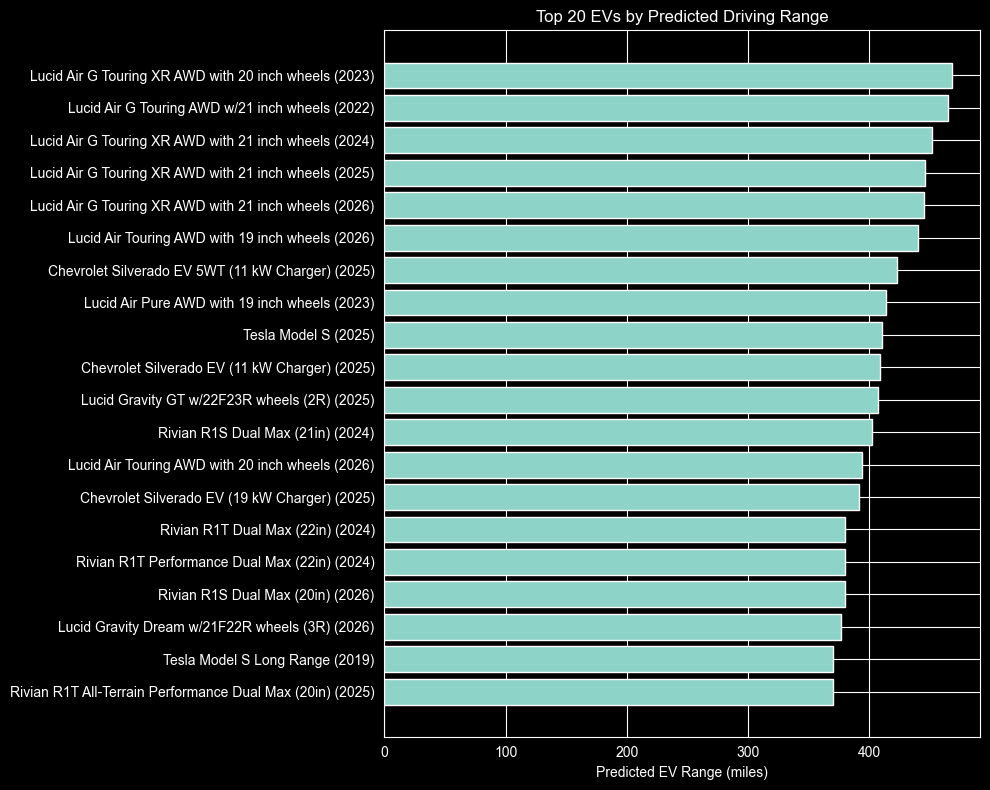

✅ Saved bar chart to: /Users/saam/PycharmProjects/ev-range-prediction/figures/top_20_ev_by_predicted_range.png


In [62]:
# ============================================
# Cell 11 — Top 20 EVs by Predicted Range (Bar Chart)
# ============================================

import matplotlib.pyplot as plt
from pathlib import Path

# --- Resolve project root ---
CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent
FIGURES_DIR = PROJECT_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

# --- Prepare data for plotting ---
plot_df = top_ev_range.copy()

# Create readable labels: "Make Model (Year)"
plot_df["label"] = (
    plot_df["make"] + " " +
    plot_df["model"] + " (" +
    plot_df["year"].astype(str) + ")"
)

# Reverse for horizontal bar plot (highest at top)
plot_df = plot_df.iloc[::-1]

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.barh(
    plot_df["label"],
    plot_df["predicted_range_miles"]
)

plt.xlabel("Predicted EV Range (miles)")
plt.title("Top 20 EVs by Predicted Driving Range")
plt.tight_layout()

# --- Save figure ---
out_path = FIGURES_DIR / "top_20_ev_by_predicted_range.png"
plt.savefig(out_path, dpi=150)
plt.show()

print("✅ Saved bar chart to:", out_path.resolve())